In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline  # this pipeline is the same from sklearn, but for imbalanced data
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate
from pprint import pprint

In [2]:
DATA = '../data/customers_clustered.csv'
RANDOM_STATE = 42

In [3]:
df_clustered = pd.read_csv(DATA)

In [4]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Marital_Status       2212 non-null   object 
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   MntWines             2212 non-null   int64  
 7   MntFruits            2212 non-null   int64  
 8   MntMeatProducts      2212 non-null   int64  
 9   MntFishProducts      2212 non-null   int64  
 10  MntSweetProducts     2212 non-null   int64  
 11  MntGoldProds         2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   i

In [5]:
X = df_clustered.drop('Response', axis=1)
y = df_clustered['Response']

In [6]:
X.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Dependents,hasDependent,AcceptedCmpTotal,hasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,16-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2


In [7]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Response, dtype: int64

In [20]:
one_hot_cols = [
    'Education',
    'Marital_Status',
    'Kidhome',
    'Teenhome',
    'AcceptedCmp3',
    'AcceptedCmp4', 
    'AcceptedCmp5', 
    'AcceptedCmp1', 
    'AcceptedCmp2',
    'Complain',
    # 'Response', 
    'hasDependent', 
    'hasAcceptedCmp', 
    'AgeGroup'
]

standard_scaler_cols = [
    'Income',
    'Age',
    'NumTotalPurchases'
]

power_cols = [
    'MntWines', 
    'MntFruits', 
    'MntMeatProducts',
    'MntFishProducts', 
    'MntSweetProducts', 
    'MntGoldProds',
    'MntTotal', 
    'MntRegularProds',
    'NumDealsPurchases', 
    'NumWebPurchases', 
    'NumCatalogPurchases',
    'NumStorePurchases', 
    'NumWebVisitsMonth'
]

min_max_scaler_cols = [
    'Recency',
    'DaysSinceEnrolled',
    'YearsSinceEnrolled',
    'Dependents',
    'AcceptedCmpTotal'
]

In [21]:
X.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'DaysSinceEnrolled', 'YearsSinceEnrolled', 'Age',
       'AgeGroup', 'MntTotal', 'MntRegularProds', 'Dependents', 'hasDependent',
       'AcceptedCmpTotal', 'hasAcceptedCmp', 'NumTotalPurchases', 'cluster'],
      dtype='object')

We are going to use the dummy classifier in a stratified way for the baseline.

In [22]:
models = {
    'dummy': DummyClassifier(strategy='stratified', random_state=RANDOM_STATE),
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'logistic_regression': LogisticRegression(random_state=RANDOM_STATE),
    'knn': KNeighborsClassifier(n_neighbors=5) 
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [23]:
def pipeline_model(X, y, model, kf):
    
    preprocessing = ColumnTransformer(
        transformers=[
            ('one_hot_encoder', OneHotEncoder(), one_hot_cols),
            ('standard', StandardScaler(), standard_scaler_cols),
            ('min_max', MinMaxScaler(), min_max_scaler_cols),
            ('power', PowerTransformer(), power_cols)
        ]
    )

    pipeline = Pipeline(
        [
            ('preprocessing', preprocessing),
            ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
            ('random_under_sampler', RandomUnderSampler(random_state=RANDOM_STATE)),
            ('model', model)
        ]
    )

    scores = cross_validate(
        pipeline, 
        X, 
        y, 
        cv=kf, 
        scoring=[
            'accuracy',
            'precision',
            'recall',
            'roc_auc',
            'average_precision'
        ],
        n_jobs=-1)

    return scores

In [24]:
results = {
    key: pipeline_model(X, y, model, skf) for key, model in models.items() 
}

In [27]:
pprint(results)

{'decision_tree': {'fit_time': array([0.16184759, 0.13664365, 0.15304422, 0.17766237, 0.18752789]),
                   'score_time': array([0.05648112, 0.05330682, 0.06480312, 0.06964922, 0.06972313]),
                   'test_accuracy': array([0.79006772, 0.70880361, 0.77828054, 0.82352941, 0.68325792]),
                   'test_average_precision': array([0.31594929, 0.27095021, 0.31448828, 0.39919495, 0.24005698]),
                   'test_precision': array([0.35227273, 0.29605263, 0.34343434, 0.43478261, 0.27710843]),
                   'test_recall': array([0.46268657, 0.67164179, 0.50746269, 0.60606061, 0.6969697 ]),
                   'test_roc_auc': array([0.69659019, 0.7001429 , 0.66674627, 0.78441328, 0.68651273])},
 'dummy': {'fit_time': array([0.16774035, 0.16044664, 0.15317512, 0.18137407, 0.18337035]),
           'score_time': array([0.08574176, 0.0757041 , 0.0894208 , 0.0769496 , 0.07379079]),
           'test_accuracy': array([0.49887133, 0.53498871, 0.49547511, 0.502262

In [28]:
for k, v in results.items():
    results[k]['time'] = results[k]['fit_time'] + results[k]['score_time']

In [30]:
pprint(results)

{'decision_tree': {'fit_time': array([0.16184759, 0.13664365, 0.15304422, 0.17766237, 0.18752789]),
                   'score_time': array([0.05648112, 0.05330682, 0.06480312, 0.06964922, 0.06972313]),
                   'test_accuracy': array([0.79006772, 0.70880361, 0.77828054, 0.82352941, 0.68325792]),
                   'test_average_precision': array([0.31594929, 0.27095021, 0.31448828, 0.39919495, 0.24005698]),
                   'test_precision': array([0.35227273, 0.29605263, 0.34343434, 0.43478261, 0.27710843]),
                   'test_recall': array([0.46268657, 0.67164179, 0.50746269, 0.60606061, 0.6969697 ]),
                   'test_roc_auc': array([0.69659019, 0.7001429 , 0.66674627, 0.78441328, 0.68651273]),
                   'time': array([0.21832871, 0.18995047, 0.21784735, 0.24731159, 0.25725102])},
 'dummy': {'fit_time': array([0.16774035, 0.16044664, 0.15317512, 0.18137407, 0.18337035]),
           'score_time': array([0.08574176, 0.0757041 , 0.0894208 , 0.0769496

In [39]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'model'})
df_results = df_results.explode(
    df_results.columns[1:].tolist()
).reset_index(drop=True)

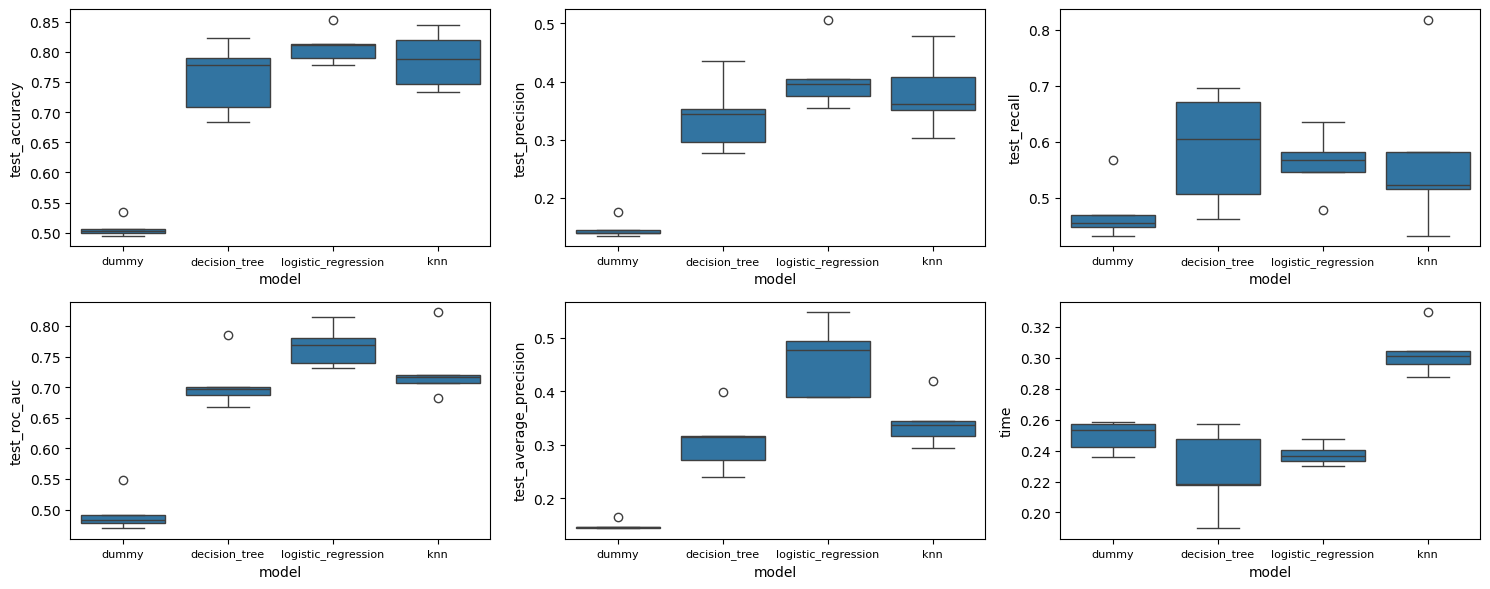

In [67]:
fig, axs = plt.subplots(ncols=3, nrows=2, tight_layout=True, figsize=(15,6))

cols = df_results.columns[3:].tolist()

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(data=df_results, y=col, ax=ax, x='model')
    ax.tick_params(axis='x', labelsize=8)

All metrics suggests the logistic regression as a good model. Comparing it to the decision tree and KNN, the logistic regression is better at roc, average_precision and total time (fit and score) and is comparable in accuracy, precision and recall. Logistic regression was also better than KNN in fit + score time.